### <b>Appendix C</b>

#### 1) Import data into pandas DataFrame

In [2]:
from pathlib import Path
import pandas as pd

PATH = Path("Datafiniti_Hotel_Reviews_Jun19.csv")
df = pd.read_csv(
    PATH, 
    usecols=[
        'id', 
        'reviews.rating', 
        'reviews.title', 
        'reviews.text',
    ],
)

df.rename(
    columns = {
        'id': 'hotel_id',
        'reviews.rating': 'rating',
        'reviews.title': 'title',
        'reviews.text': 'text',
    }, 
    inplace = True
) 

og_row_count = df.shape[0]
df = df.drop_duplicates()
new_row_count = df.shape[0]

num_duplicates = og_row_count - new_row_count
print("Dropped {0} duplicate columns".format(num_duplicates))

Dropped 213 duplicate columns


#### 2) Create long short-term memory (LSTM) model

In [5]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Embedding, LSTM, Dense

data = df.copy()
data['text'] = data['text'].apply(
    (lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim, mask_zero=True))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(5, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Y = pd.get_dummies(data['rating']).values
X_train, X_test, Y_train, y_test = train_test_split(X,Y, test_size = 0.20)

history = model.fit(
    X_train, Y_train, batch_size=batch_size, epochs =4, verbose = 1, 
    validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
print("Score: {}".format(score))
print("Accuracy: {0:.2f}".format(acc * 100))

Epoch 1/4
245/245 [==============================] - 1371s 6s/step - loss: 1.1468 - accuracy: 0.5071 - val_loss: 1.0158 - val_accuracy: 0.5199
Epoch 2/4
245/245 [==============================] - 1296s 5s/step - loss: 0.9606 - accuracy: 0.5747 - val_loss: 0.9704 - val_accuracy: 0.5562
Epoch 3/4
245/245 [==============================] - 1340s 5s/step - loss: 0.8950 - accuracy: 0.6172 - val_loss: 1.3192 - val_accuracy: 0.4295
Epoch 4/4
245/245 [==============================] - 1291s 5s/step - loss: 0.8627 - accuracy: 0.6300 - val_loss: 1.0117 - val_accuracy: 0.5536
62/62 - 44s - loss: 1.0117 - accuracy: 0.5536
Score: 1.011698603630066
Accuracy: 55.36


In [7]:
model.save('lstm_model.h5')

In [9]:
y_predicted = model.predict(X_test)

In [1]:
from keras.models import load_model

model.save('lstm_model.h5')

NameError: name 'model' is not defined

In [11]:
print(y_predicted.argmax(axis=1)[:100])

[4 3 3 2 4 0 4 4 4 0 0 2 0 2 4 3 3 3 4 4 4 4 2 0 4 4 4 4 3 4 3 4 0 4 3 2 4
 3 4 4 3 4 3 4 4 4 4 4 4 4 3 3 3 3 4 4 4 4 3 3 3 4 4 4 4 4 4 4 0 3 4 4 4 4
 4 3 4 2 4 3 4 3 3 4 4 3 4 4 2 2 4 3 3 3 4 2 4 4 2 3]


#### 3) Validate LSTM model

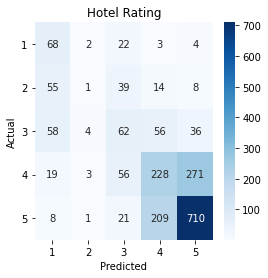

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from pandas import DataFrame


def display_hotel_rating_pred_confusion_matrix(
    y_test: pd.core.series.Series, y_predicted: pd.core.series.Series) -> None:
    """Display confusion matrix for predictions."""
    
#     cm = metrics.confusion_matrix(y_test.values, y_predicted)
    cm = metrics.confusion_matrix(
        y_test.argmax(axis=1), y_predicted.argmax(axis=1))
    
    # Show confusion matrix with colored background.
    labels = [str(num) for num in range(1, 6)]
    index = labels
    cols = labels
    df = DataFrame(cm, index=index, columns=cols)
    plt.figure(figsize = (4,4))
    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title = 'Hotel Rating')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_ylim(bottom, top)
    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=0, horizontalalignment='center')
    ax.set_yticklabels(
        ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    

display_hotel_rating_pred_confusion_matrix(y_test, y_predicted)

In [15]:
from sklearn.metrics import classification_report

classification_report = classification_report(
    y_test.argmax(axis=1), y_predicted.argmax(axis=1))
print(classification_report)

              precision    recall  f1-score   support

           0       0.33      0.69      0.44        99
           1       0.09      0.01      0.02       117
           2       0.31      0.29      0.30       216
           3       0.45      0.40      0.42       577
           4       0.69      0.75      0.72       949

    accuracy                           0.55      1958
   macro avg       0.37      0.43      0.38      1958
weighted avg       0.52      0.55      0.53      1958



In [21]:
import math

rmse2 = math.sqrt(metrics.mean_squared_error(
    y_test.argmax(axis=1), y_predicted.argmax(axis=1)))
print("RMSE: {:.4f}".format(rmse2))

RMSE: 0.9532
